In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
meas = Base.classes.measurement
stns = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Create the inspector and connect it to the engine

In [24]:
inspector = inspect(engine)

In [26]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [148]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Find the most recent date in the data set.
dt_last_str = session.query(func.max(meas.date)).one()[0]
dt_last_str

'2017-08-23'

In [95]:
# Starting from the most recent data point in the database. 
dt_last = dt.datetime.strptime(dt_last_str,"%Y-%m-%d")
dt_last

datetime.datetime(2017, 8, 23, 0, 0)

In [102]:
# Calculate the date one year from the last date in data set.
dt_start = dt_last - dt.timedelta(days=366)
dt_start

datetime.datetime(2016, 8, 22, 0, 0)

In [145]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(meas.date,meas.prcp).order_by(meas.date).filter(meas.date>dt_start).all()

In [150]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp,columns=['Date','Precipitation'])
# Sort the dataframe by date
prcp_df = prcp_df.sort_values('Date')
prcp_df

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2228,2017-08-23,0.08
2226,2017-08-23,0.00
2227,2017-08-23,0.00


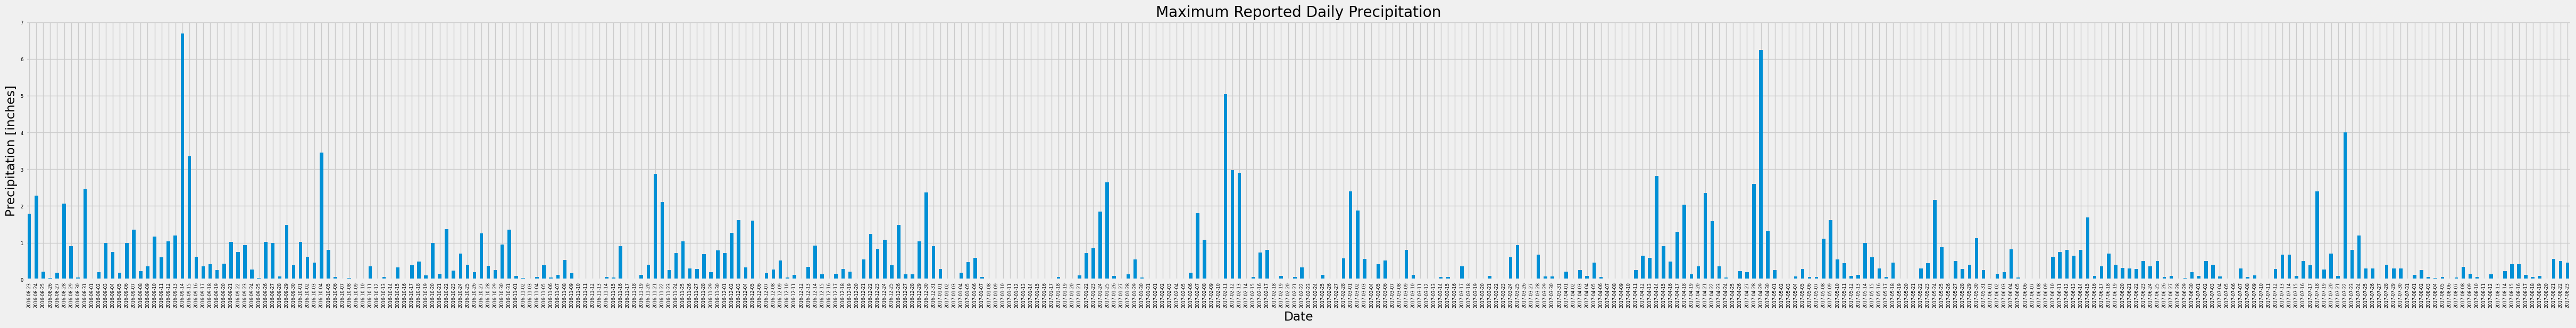

In [116]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.groupby("Date").max().plot.bar(
    figsize=(55,6), fontsize=6, legend=None
)
plt.title('Maximum Reported Daily Precipitation')
plt.ylabel('Precipitation [inches]')
plt.show()

In [112]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [61]:
# Design a query to calculate the total number of stations in the dataset
session.query(meas.station).distinct().count()

9

In [69]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(meas.station,func.count(meas.station)).group_by(meas.station).order_by(func.count(meas.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(meas.tobs),func.max(meas.tobs),func.avg(meas.tobs)).filter(meas.station=='USC00519281').one()

(54.0, 85.0, 71.66378066378067)

In [144]:
# Using the most active station id query the last 12 months of temperature observation data for this station
temp = session.query(meas.date,meas.tobs).order_by(meas.date).filter(meas.date>dt_start).filter(meas.station=='USC00519281').all()

In [119]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
temp_df = pd.DataFrame(temp,columns=['Date','Temperature'])

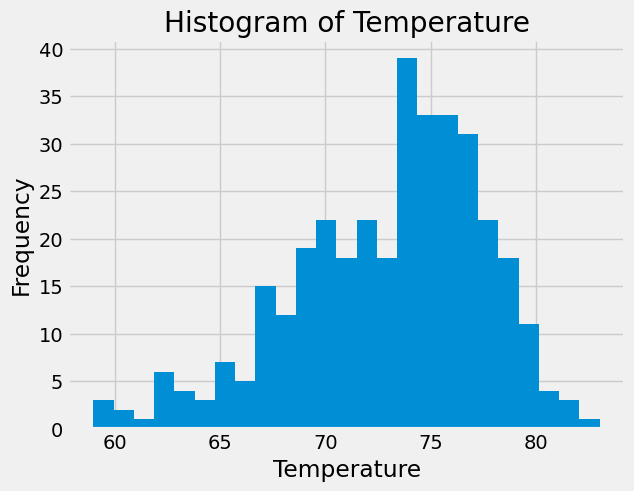

In [146]:
# Plot the results as a histogram for each unique temperature
temp_df.hist(bins=len(temp_df['Temperature'].unique().tolist()))
plt.title('Histogram of Temperature')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

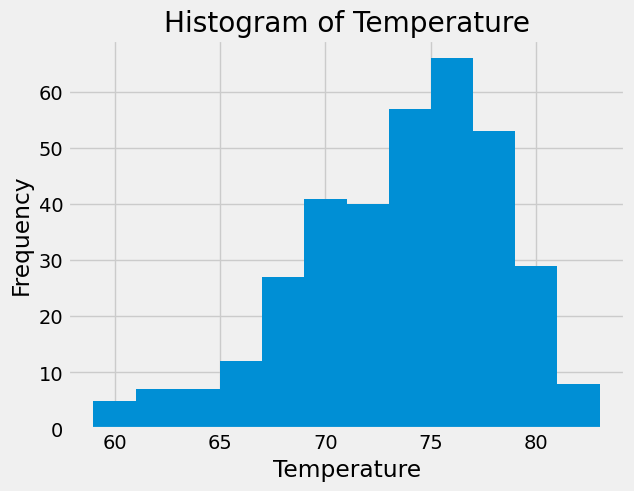

In [151]:
# Plot the results as a histogram with bins=12
temp_df.hist(bins=12)
plt.title('Histogram of Temperature')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

# Close Session

In [147]:
# Close Session
session.close()